Trabajo Práctico 3

<>:65: SyntaxWarning: invalid escape sequence '\e'
<>:65: SyntaxWarning: invalid escape sequence '\s'
<>:65: SyntaxWarning: invalid escape sequence '\e'
<>:65: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\478840863.py:65: SyntaxWarning: invalid escape sequence '\e'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\478840863.py:65: SyntaxWarning: invalid escape sequence '\s'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
100%|██████████| 2000/2000 [05:44<00:00,  5.80it/s]


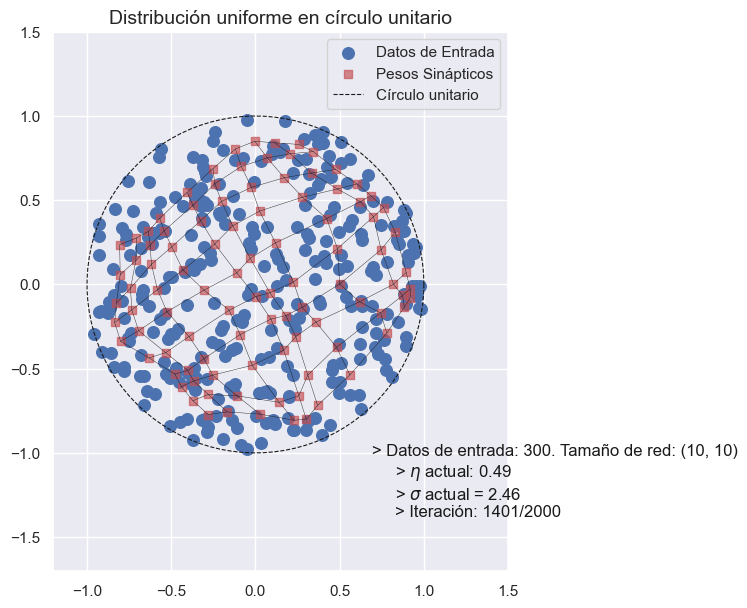

In [2]:
import sys
import time
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set(style="darkgrid", context="notebook")
np.set_printoptions(threshold=sys.maxsize)

# Neighborhood function
def neighborhood_function(distance, sigma):
    return np.exp(-distance**2 / sigma)

# Initialize weights uniformly within a small range
def initialize_weights(shape, scale=0.1):
    return np.random.uniform(-scale, scale, shape)

# Generate uniform distribution within a circle
def uniform_circle_init(N, radius=1, center=(0.,0.)):
    r = np.sqrt(np.random.uniform(0, radius, N))
    phi = np.random.uniform(0, 2*np.pi, N)
    return np.array([r*np.cos(phi), r*np.sin(phi)]).T + center

# Compute Euclidean distances between all neurons and the winner neuron
def compute_all_euclidean_distances_from_winner(grid_shape, winner):
    distances = np.zeros(grid_shape)
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            distances[i][j] = np.linalg.norm(np.array([i, j]) - np.array(winner))
    return distances

# Update weights based on the neighborhood function and learning rate
def update_weights(neighborhood_function, W, winner_indexes, x, distances, eta=1, sigma=1):
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] += eta * neighborhood_function(distances[i, j], sigma) * (x - W[i, j])
    return W

# Plot synaptic connections
def plot_synaptic_connections(ax, W):
    grid_height, grid_width, _ = W.shape
    for i in range(grid_height):
        for j in range(grid_width):
            if i < grid_height - 1:
                ax.plot([W[i, j, 0], W[i + 1, j, 0]], [W[i, j, 1], W[i + 1, j, 1]], color='k', linewidth=0.3)
            if j < grid_width - 1:
                ax.plot([W[i, j, 0], W[i, j + 1, 0]], [W[i, j, 1], W[i, j + 1, 1]], color='k', linewidth=0.3)

# Update the graph with current state of the weights and input data
def update_graph(W, X, plot_parameters, parameters_info):
    fig, ax, boundaries, x_lim, y_lim, pause, title, _ = plot_parameters
    input_size, network_shape, eta, sigma, iterations, it = parameters_info
    ax.cla()
    ax.grid(True)
    plot_synaptic_connections(ax, W)
    ax.scatter(X[:, 0], X[:, 1], color='b', label='Datos de Entrada', s=70)
    ax.scatter(W[:, :, 0].flatten(), W[:, :, 1].flatten(), color='r', label='Pesos Sinápticos', marker='s', s=30, alpha=0.65)
    for boundary in boundaries:
        x, y, line_fmt, line_width, label_b = boundary
        ax.plot(x, y, line_fmt, linewidth=line_width, label=label_b)
    ax.text(0.7, 0.1, f'> Datos de entrada: {input_size}. Tamaño de red: ({network_shape[0]}, {network_shape[1]})\n \
    > $\eta$ actual: {eta:.2f}\n \
    > $\sigma$ actual = {sigma:.2f}\n \
    > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    fig.canvas.draw()
    if pause > 0:
        time.sleep(pause)

# Train the Kohonen network
def kohonen_train(W, X, grid_shape, distances_function, neighborhood_function,
                  plot_parameters=None, eta=1, eta_decay=0.999, sigma=1, sigma_decay=0.999, iterations_amount=100):
    eta_initial = eta
    sigma_initial = sigma
    intervals = [0.2, 0.5, 0.7, 1.0]
    for it in tqdm(range(iterations_amount)):
        np.random.shuffle(X)
        for x in X:
            winner_indexes = np.unravel_index(np.argmin(np.linalg.norm(W - x, axis=-1)), W.shape[:2])
            distances = distances_function(grid_shape, winner_indexes)
            W = update_weights(neighborhood_function, W, winner_indexes, x, distances, eta, sigma)
        if plot_parameters is not None and (it / iterations_amount) in intervals:
            parameters_info = (len(X), W.shape, eta, sigma, iterations_amount, it+1)
            update_graph(W, X, plot_parameters, parameters_info)
        sigma *= sigma_decay
        eta *= eta_decay
    return W

# Plot the initial graph
def initial_plot(W, X, plot_parameters):
    update_graph(W, X, plot_parameters, (len(X), W.shape, eta_initial, sigma_initial, iterations, 0))

# Meta-parameters
grid_shape = (10, 10)
input_size = 2
eta_initial = 2
eta_decay = 0.999
sigma_initial = 10
sigma_decay = 0.999
iterations = 2000

# Generate input data and initial weights
center = (0, 0)
radius = 1
X = uniform_circle_init(grid_shape[0] * grid_shape[1] * 3, radius=radius, center=center)
W = np.reshape(initialize_weights((grid_shape[0], grid_shape[1], input_size), scale=0.1), (grid_shape[0], grid_shape[1], input_size))

# Plot parameters
x_lim = np.array([-1.2, 1.5])*radius + center
y_lim = np.array([-1.7, 1.5])*radius + center
update_interval = 10

# Boundary:
circ_values = np.linspace(0, 2*np.pi, 100)
line_fmts = '--k'
line_widths= 0.8
labels = 'Círculo unitario'
boundary = [(radius*np.cos(circ_values), radius*np.sin(circ_values), line_fmts, line_widths, labels)]

fig, ax = plt.subplots(figsize=(14, 7))
pause = 0
title = 'Distribución uniforme en círculo unitario'
plot_parameters = (fig, ax, boundary, x_lim, y_lim, pause, title, update_interval)
initial_plot(W, X, plot_parameters)
W = kohonen_train(W, X, grid_shape, compute_all_euclidean_distances_from_winner, neighborhood_function,
                  plot_parameters, eta=eta_initial, eta_decay=eta_decay, sigma=sigma_initial,
                  sigma_decay=sigma_decay, iterations_amount=iterations)

plt.show()



<>:59: SyntaxWarning: invalid escape sequence '\e'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\e'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\1538037477.py:59: SyntaxWarning: invalid escape sequence '\e'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\1538037477.py:59: SyntaxWarning: invalid escape sequence '\s'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)


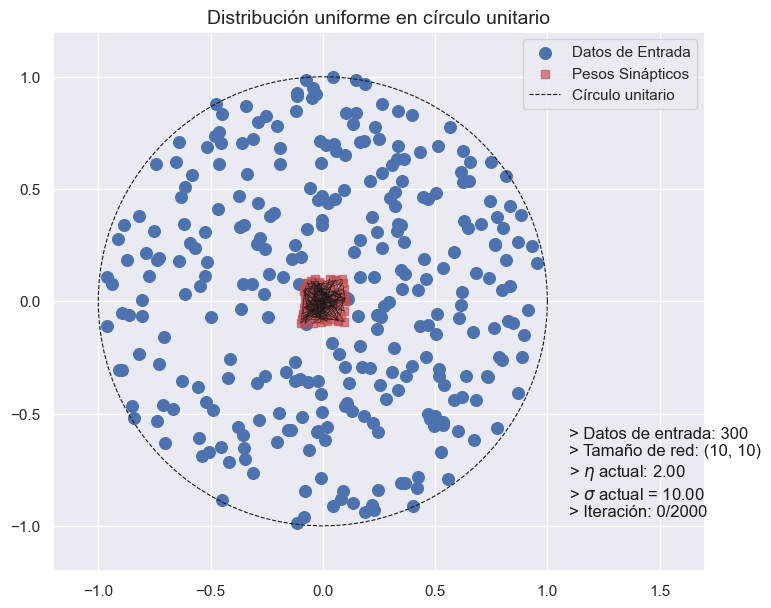

  1%|          | 18/2000 [00:03<06:10,  5.35it/s]
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\1538037477.py:59: SyntaxWarning: invalid escape sequence '\e'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\1538037477.py:59: SyntaxWarning: invalid escape sequence '\s'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)


KeyboardInterrupt: 

In [22]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

#sns.set(style="darkgrid", context="notebook")
#np.set_printoptions(threshold=np.inf)

def neighborhoodFunction(distance, sigma):
    return np.exp(-distance**2 / sigma)

def initializeWeights(shape, scale=0.1):
    return np.random.uniform(-scale, scale, shape)

def uniformCircleInit(N, radius=1, center=(0., 0.)):
    r = np.sqrt(np.random.uniform(0, radius, N))
    phi = np.random.uniform(0, 2 * np.pi, N)
    return np.array([r * np.cos(phi), r * np.sin(phi)]).T + center

def computeEuclideanDistances(gridShape, winner):
    distances = np.zeros(gridShape)
    for i in range(gridShape[0]):
        for j in range(gridShape[1]):
            distances[i, j] = np.linalg.norm(np.array([i, j]) - np.array(winner))
    return distances

def updateWeights(neighborhoodFunction, W, winnerIndexes, x, distances, eta=1, sigma=1):
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] += eta * neighborhoodFunction(distances[i, j], sigma) * (x - W[i, j])
    return W

def plotSynapticConnections(ax, W):
    gridHeight, gridWidth, _ = W.shape
    for i in range(gridHeight):
        for j in range(gridWidth):
            if i < gridHeight - 1:
                ax.plot([W[i, j, 0], W[i + 1, j, 0]], [W[i, j, 1], W[i + 1, j, 1]], color='k', linewidth=0.3)
            if j < gridWidth - 1:
                ax.plot([W[i, j, 0], W[i, j + 1, 0]], [W[i, j, 1], W[i, j + 1, 1]], color='k', linewidth=0.3)

def updateGraph(W, X, plotParameters, parametersInfo):
    fig, ax, boundaries, xLim, yLim, title = plotParameters
    inputSize, networkShape, eta, sigma, iterations, it = parametersInfo
    #ax.cla()
    ax.grid(True)
    plotSynapticConnections(ax, W)
    ax.scatter(X[:, 0], X[:, 1], color='b', label='Datos de Entrada', s=70)
    ax.scatter(W[:, :, 0].flatten(), W[:, :, 1].flatten(), color='r', label='Pesos Sinápticos', marker='s', s=30, alpha=0.65)
    for boundary in boundaries:
        x, y, lineFmt, lineWidth, labelB = boundary
        ax.plot(x, y, lineFmt, linewidth=lineWidth, label=labelB)
    ax.text(0.7, 0.1, 
            f' \n \
            > Datos de entrada: {inputSize}\n \
            > Tamaño de red: ({networkShape[0]}, {networkShape[1]})\n \
            > $\eta$ actual: {eta:.2f}\n \
            > $\sigma$ actual = {sigma:.2f}\n \
            > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(xLim)
    ax.set_ylim(yLim)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    #fig.canvas.draw()
    plt.pause(0.1)

def kohonenTrain(W, X, gridShape, distancesFunction, neighborhoodFunction, plotParameters, eta=1, etaDecay=0.999, sigma=1, sigmaDecay=0.999, iterationsAmount=100):
    etaInitial = eta
    sigmaInitial = sigma
    intervals = [0.2, 0.5, 0.7, 1.0]
    for it in tqdm(range(iterationsAmount)):
        np.random.shuffle(X)
        for x in X:
            winnerIndexes = np.unravel_index(np.argmin(np.linalg.norm(W - x, axis=-1)), W.shape[:2])
            distances = distancesFunction(gridShape, winnerIndexes)
            W = updateWeights(neighborhoodFunction, W, winnerIndexes, x, distances, eta, sigma)
        if plotParameters is not None and (it + 1) / iterationsAmount in intervals:
            parametersInfo = (len(X), W.shape, eta, sigma, iterationsAmount, it + 1)
            updateGraph(W, X, plotParameters, parametersInfo)
        sigma *= sigmaDecay
        eta *= etaDecay
    return W

def initialPlot(W, X, plotParameters):
    updateGraph(W, X, plotParameters, (len(X), W.shape, etaInitial, sigmaInitial, iterations, 0))

# Meta-parameters
gridShape = (10, 10)
inputSize = 2
etaInitial = 2
etaDecay = 0.999
sigmaInitial = 10
sigmaDecay = 0.999
iterations = 2000

# Generate input data and initial weights
center = (0, 0)
radius = 1
X = uniformCircleInit(gridShape[0] * gridShape[1] * 3, radius=radius, center=center)
W = initializeWeights((gridShape[0], gridShape[1], inputSize), scale=0.1)

# Plot parameters
xLim = np.array([-1.2, 1.7]) * radius + center
yLim = np.array([-1.2, 1.2]) * radius + center

# Boundary
circValues = np.linspace(0, 2 * np.pi, 100)
lineFmts = '--k'
lineWidths = 0.8
labels = 'Círculo unitario'
boundary = [(radius * np.cos(circValues), radius * np.sin(circValues), lineFmts, lineWidths, labels)]

fig, ax = plt.subplots(figsize=(14, 7))
title = 'Distribución uniforme en círculo unitario'
plotParameters = (fig, ax, boundary, xLim, yLim, title)

# Plot initial state
initialPlot(W, X, plotParameters)

# Train the network
W = kohonenTrain(W, X, gridShape, computeEuclideanDistances, neighborhoodFunction, plotParameters, eta=etaInitial, etaDecay=etaDecay, sigma=sigmaInitial, sigmaDecay=sigmaDecay, iterationsAmount=iterations)

plt.show()

<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\s'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\2640643567.py:54: SyntaxWarning: invalid escape sequence '\e'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_26244\2640643567.py:54: SyntaxWarning: invalid escape sequence '\s'
  > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)


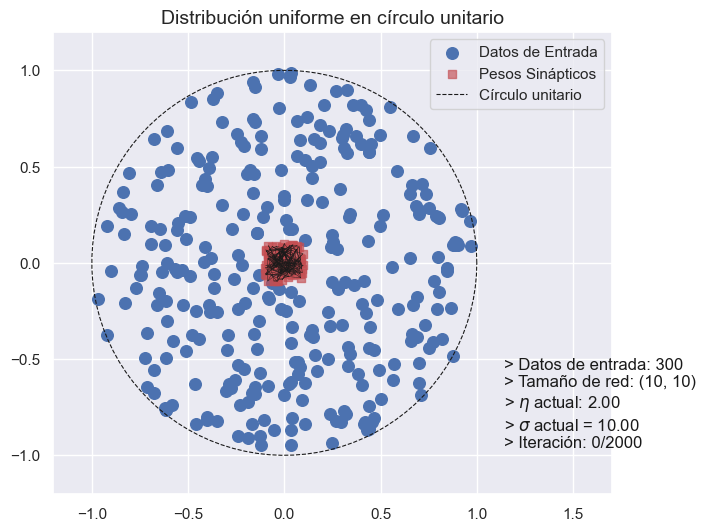

 10%|▉         | 199/2000 [00:46<07:03,  4.25it/s]

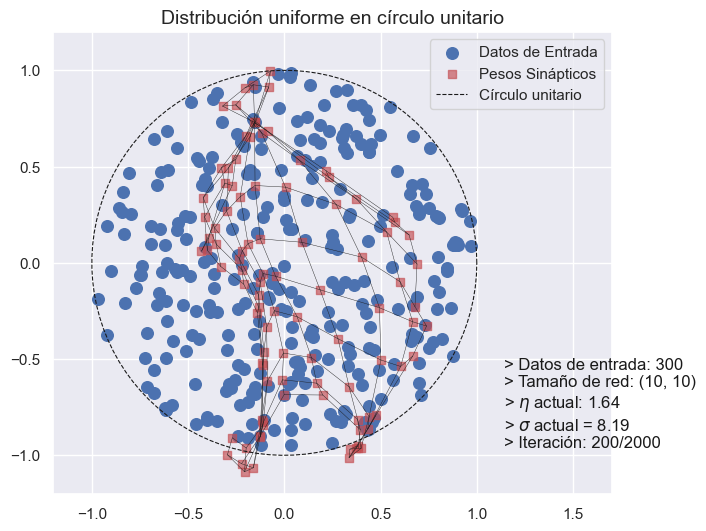

 25%|██▍       | 499/2000 [01:57<05:37,  4.45it/s]

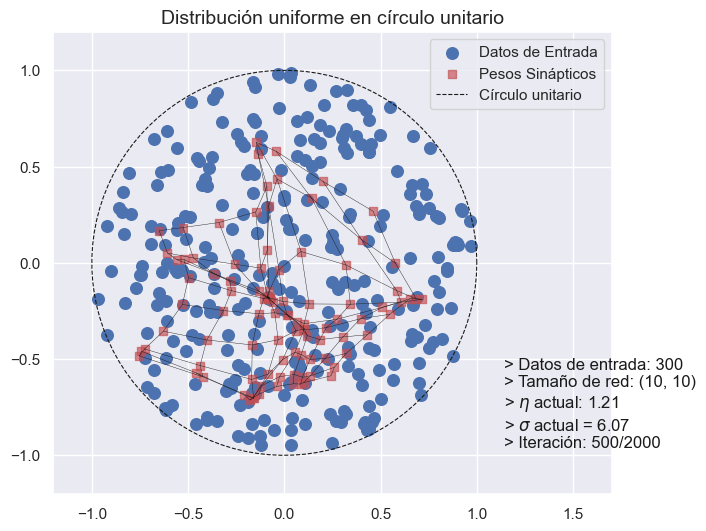

 50%|████▉     | 999/2000 [03:59<04:10,  3.99it/s]

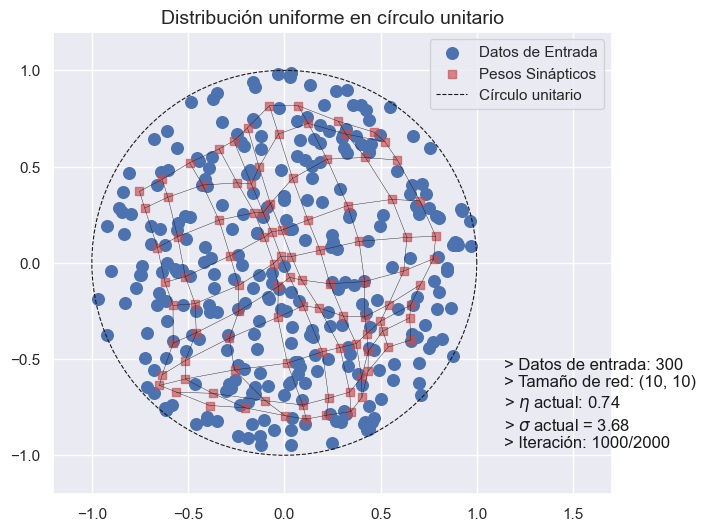

 75%|███████▍  | 1499/2000 [05:56<01:50,  4.53it/s]

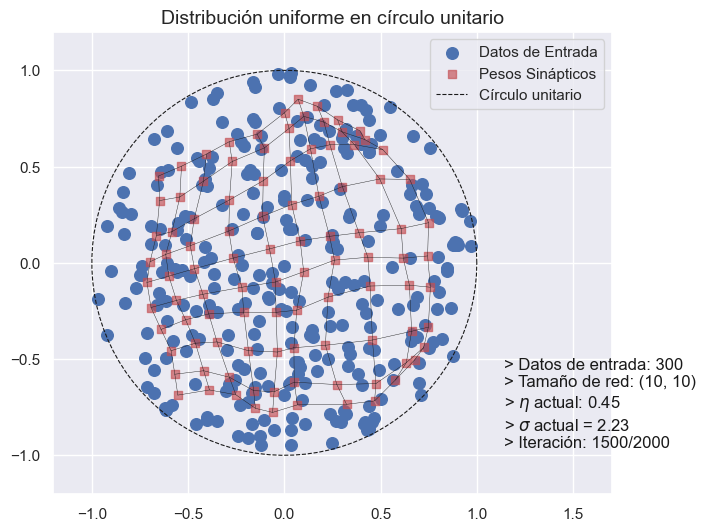

100%|█████████▉| 1999/2000 [07:54<00:00,  4.67it/s]

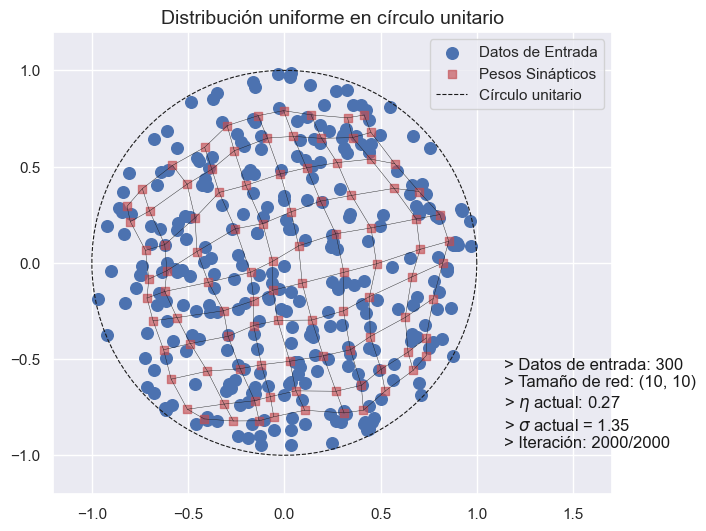

100%|██████████| 2000/2000 [07:55<00:00,  4.21it/s]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def neighborhoodFunction(distance, sigma):
    return np.exp(-distance**2 / sigma)

def initializeWeights(shape, scale=0.1):
    return np.random.uniform(-scale, scale, shape)

def uniformCircleInit(N, radius=1, center=(0., 0.)):
    r = np.sqrt(np.random.uniform(0, radius, N))
    phi = np.random.uniform(0, 2 * np.pi, N)
    return np.array([r * np.cos(phi), r * np.sin(phi)]).T + center

def computeEuclideanDistances(gridShape, winner):
    distances = np.zeros(gridShape)
    for i in range(gridShape[0]):
        for j in range(gridShape[1]):
            distances[i, j] = np.linalg.norm(np.array([i, j]) - np.array(winner))
    return distances

def updateWeights(neighborhoodFunction, W, winnerIndexes, x, distances, eta=1, sigma=1):
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] += eta * neighborhoodFunction(distances[i, j], sigma) * (x - W[i, j])
    return W

def plotSynapticConnections(ax, W):
    gridHeight, gridWidth, _ = W.shape
    for i in range(gridHeight):
        for j in range(gridWidth):
            if i < gridHeight - 1:
                ax.plot([W[i, j, 0], W[i + 1, j, 0]], [W[i, j, 1], W[i + 1, j, 1]], color='k', linewidth=0.3)
            if j < gridWidth - 1:
                ax.plot([W[i, j, 0], W[i, j + 1, 0]], [W[i, j, 1], W[i, j + 1, 1]], color='k', linewidth=0.3)

def updateGraph(W, X, plotParameters, parametersInfo, save=False):
    fig, ax, boundaries, xLim, yLim, title = plotParameters
    inputSize, networkShape, eta, sigma, iterations, it = parametersInfo
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(True)
    plotSynapticConnections(ax, W)
    ax.scatter(X[:, 0], X[:, 1], color='b', label='Datos de Entrada', s=70)
    ax.scatter(W[:, :, 0].flatten(), W[:, :, 1].flatten(), color='r', label='Pesos Sinápticos', marker='s', s=30, alpha=0.65)
    for boundary in boundaries:
        x, y, lineFmt, lineWidth, labelB = boundary
        ax.plot(x, y, lineFmt, linewidth=lineWidth, label=labelB)
    ax.text(0.7, 0.1, f' \n \
            > Datos de entrada: {inputSize}\n \
            > Tamaño de red: ({networkShape[0]}, {networkShape[1]})\n \
            > $\eta$ actual: {eta:.2f}\n \
            > $\sigma$ actual = {sigma:.2f}\n \
            > Iteración: {it}/{iterations}', color='k', size=12, transform=ax.transAxes)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(xLim)
    ax.set_ylim(yLim)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    plt.show()
    if save:
        fig.savefig(f'kohonen_training_{it}.png')
    plt.pause(0.1)

def kohonenTrain(W, X, gridShape, distancesFunction, neighborhoodFunction, plotParameters, eta=1, etaDecay=0.999, sigma=1, sigmaDecay=0.999, iterationsAmount=100):
    etaInitial = eta
    sigmaInitial = sigma
    intervals = [0.1, 0.25, 0.5, 0.75, 1.0]
    for it in tqdm(range(iterationsAmount)):
        np.random.shuffle(X)
        for x in X:
            winnerIndexes = np.unravel_index(np.argmin(np.linalg.norm(W - x, axis=-1)), W.shape[:2])
            distances = distancesFunction(gridShape, winnerIndexes)
            W = updateWeights(neighborhoodFunction, W, winnerIndexes, x, distances, eta, sigma)
        if plotParameters is not None and (it + 1) / iterationsAmount in intervals:
            parametersInfo = (len(X), W.shape, eta, sigma, iterationsAmount, it + 1)
            updateGraph(W, X, plotParameters, parametersInfo)
        sigma *= sigmaDecay
        eta *= etaDecay
    return W

def initialPlot(W, X, plotParameters):
    parametersInfo = (len(X), W.shape, etaInitial, sigmaInitial, iterations, 0)
    updateGraph(W, X, plotParameters, parametersInfo, save=True)

# Meta-parameters
gridShape = (10, 10)
inputSize = 2
etaInitial = 2
etaDecay = 0.999
sigmaInitial = 10
sigmaDecay = 0.999
iterations = 2000

# Generate input data and initial weights
center = (0, 0)
radius = 1
X = uniformCircleInit(gridShape[0] * gridShape[1] * 3, radius=radius, center=center)
W = initializeWeights((gridShape[0], gridShape[1], inputSize), scale=0.1)

# Plot parameters
xLim = np.array([-1.2, 1.7]) * radius + center
yLim = np.array([-1.2, 1.2]) * radius + center

# Boundary
circValues = np.linspace(0, 2 * np.pi, 100)
lineFmts = '--k'
lineWidths = 0.8
labels = 'Círculo unitario'
boundary = [(radius * np.cos(circValues), radius * np.sin(circValues), lineFmts, lineWidths, labels)]

title = 'Distribución uniforme en círculo unitario'
plotParameters = (None, None, boundary, xLim, yLim, title)

# Plot initial state
initialPlot(W, X, plotParameters)

# Train the network
W = kohonenTrain(W, X, gridShape, computeEuclideanDistances, neighborhoodFunction, plotParameters, eta=etaInitial, etaDecay=etaDecay, sigma=sigmaInitial, sigmaDecay=sigmaDecay, iterationsAmount=iterations)
